In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load data

In [2]:
def load_and_combine_data(folder_path, features, feature_selection=False):
    for file in os.listdir(folder_path):
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath)

        df_selected = pd.DataFrame()

        if feature_selection:
            df_selected = pd.concat([df_selected, df[features]])

        else:
            df_selected = pd.concat([df_selected, df.drop(' Label', axis=1)])

        df_selected.columns = [col.strip() for col in df_selected.columns]

        return df_selected
    
# Features according to paper   
selected_features = [' Flow Duration', ' Fwd Packet Length Mean', ' Max Packet Length', 
                     ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
                     ' Average Packet Size', ' Avg Fwd Segment Size', 'Init_Win_bytes_forward', ' Label']

df = load_and_combine_data('./MachineLearningCSV/MachineLearningCVE', selected_features, feature_selection=True)
df.shape

(225745, 10)

Preprocess

In [3]:
# Drop missing data (we do not have missing data in the dataset, this is added to make sure 
# missing data doesn't break this code if reused with a different dataset)
df.dropna(inplace=True)

# Dropping duplicates
df.drop_duplicates(inplace=True)

In [4]:
df.shape

(215044, 10)

In [5]:
# Encode label column

df['Label'] = df['Label'].apply(lambda x: 0 if x=='BENIGN' else 1)

In [6]:
# Train_Test_Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Label'], axis=1), df['Label'], stratify=df['Label'], shuffle=True, test_size=0.2, random_state=42)

In [7]:
print(y_train.value_counts())
print(y_test.value_counts())

Label
1    101982
0     70053
Name: count, dtype: int64
Label
1    25496
0    17513
Name: count, dtype: int64


In [8]:
# Feature Scaling - Normalizing data to 0 mean and unit variance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [9]:
X_train_scaled.describe()

,Flow Duration,Fwd Packet Length Mean,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Fwd Segment Size,Init_Win_bytes_forward
count,1.720350e+05,1.720350e+05,1.720350e+05,1.720350e+05,1.720350e+05,1.720350e+05,1.720350e+05,1.720350e+05,1.720350e+05
mean,-2.383654e-17,1.576841e-17,8.283676e-18,-2.887645e-16,1.143323e-16,1.461324e-17,1.040351e-16,1.576841e-17,-4.517430e-19
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-5.307467e-01,-3.323183e-01,-8.797367e-01,-9.561040e-01,-8.896493e-01,-7.014279e-01,-9.515690e-01,-3.323183e-01,-5.454289e-01
25%,-5.270875e-01,-3.206864e-01,-8.781735e-01,-9.454277e-01,-8.896493e-01,-7.014279e-01,-9.396558e-01,-3.206864e-01,-5.169480e-01
50%,-4.766212e-01,-3.155167e-01,-5.214860e-01,-5.939556e-01,-5.493976e-01,-6.560930e-01,-6.021158e-01,-3.155167e-01,-5.136046e-01
75%,-2.424638e-01,-2.702816e-01,6.418521e-01,1.112794e+00,7.848540e-01,3.965756e-01,1.100498e+00,-2.702816e-01,4.691091e-01
max,3.207204e+00,7.164423e+00,2.163441e+00,2.490280e+00,2.815556e+00,4.677585e+00,3.063965e+00,7.164423e+00,7.569884e+00


Checking Correlations

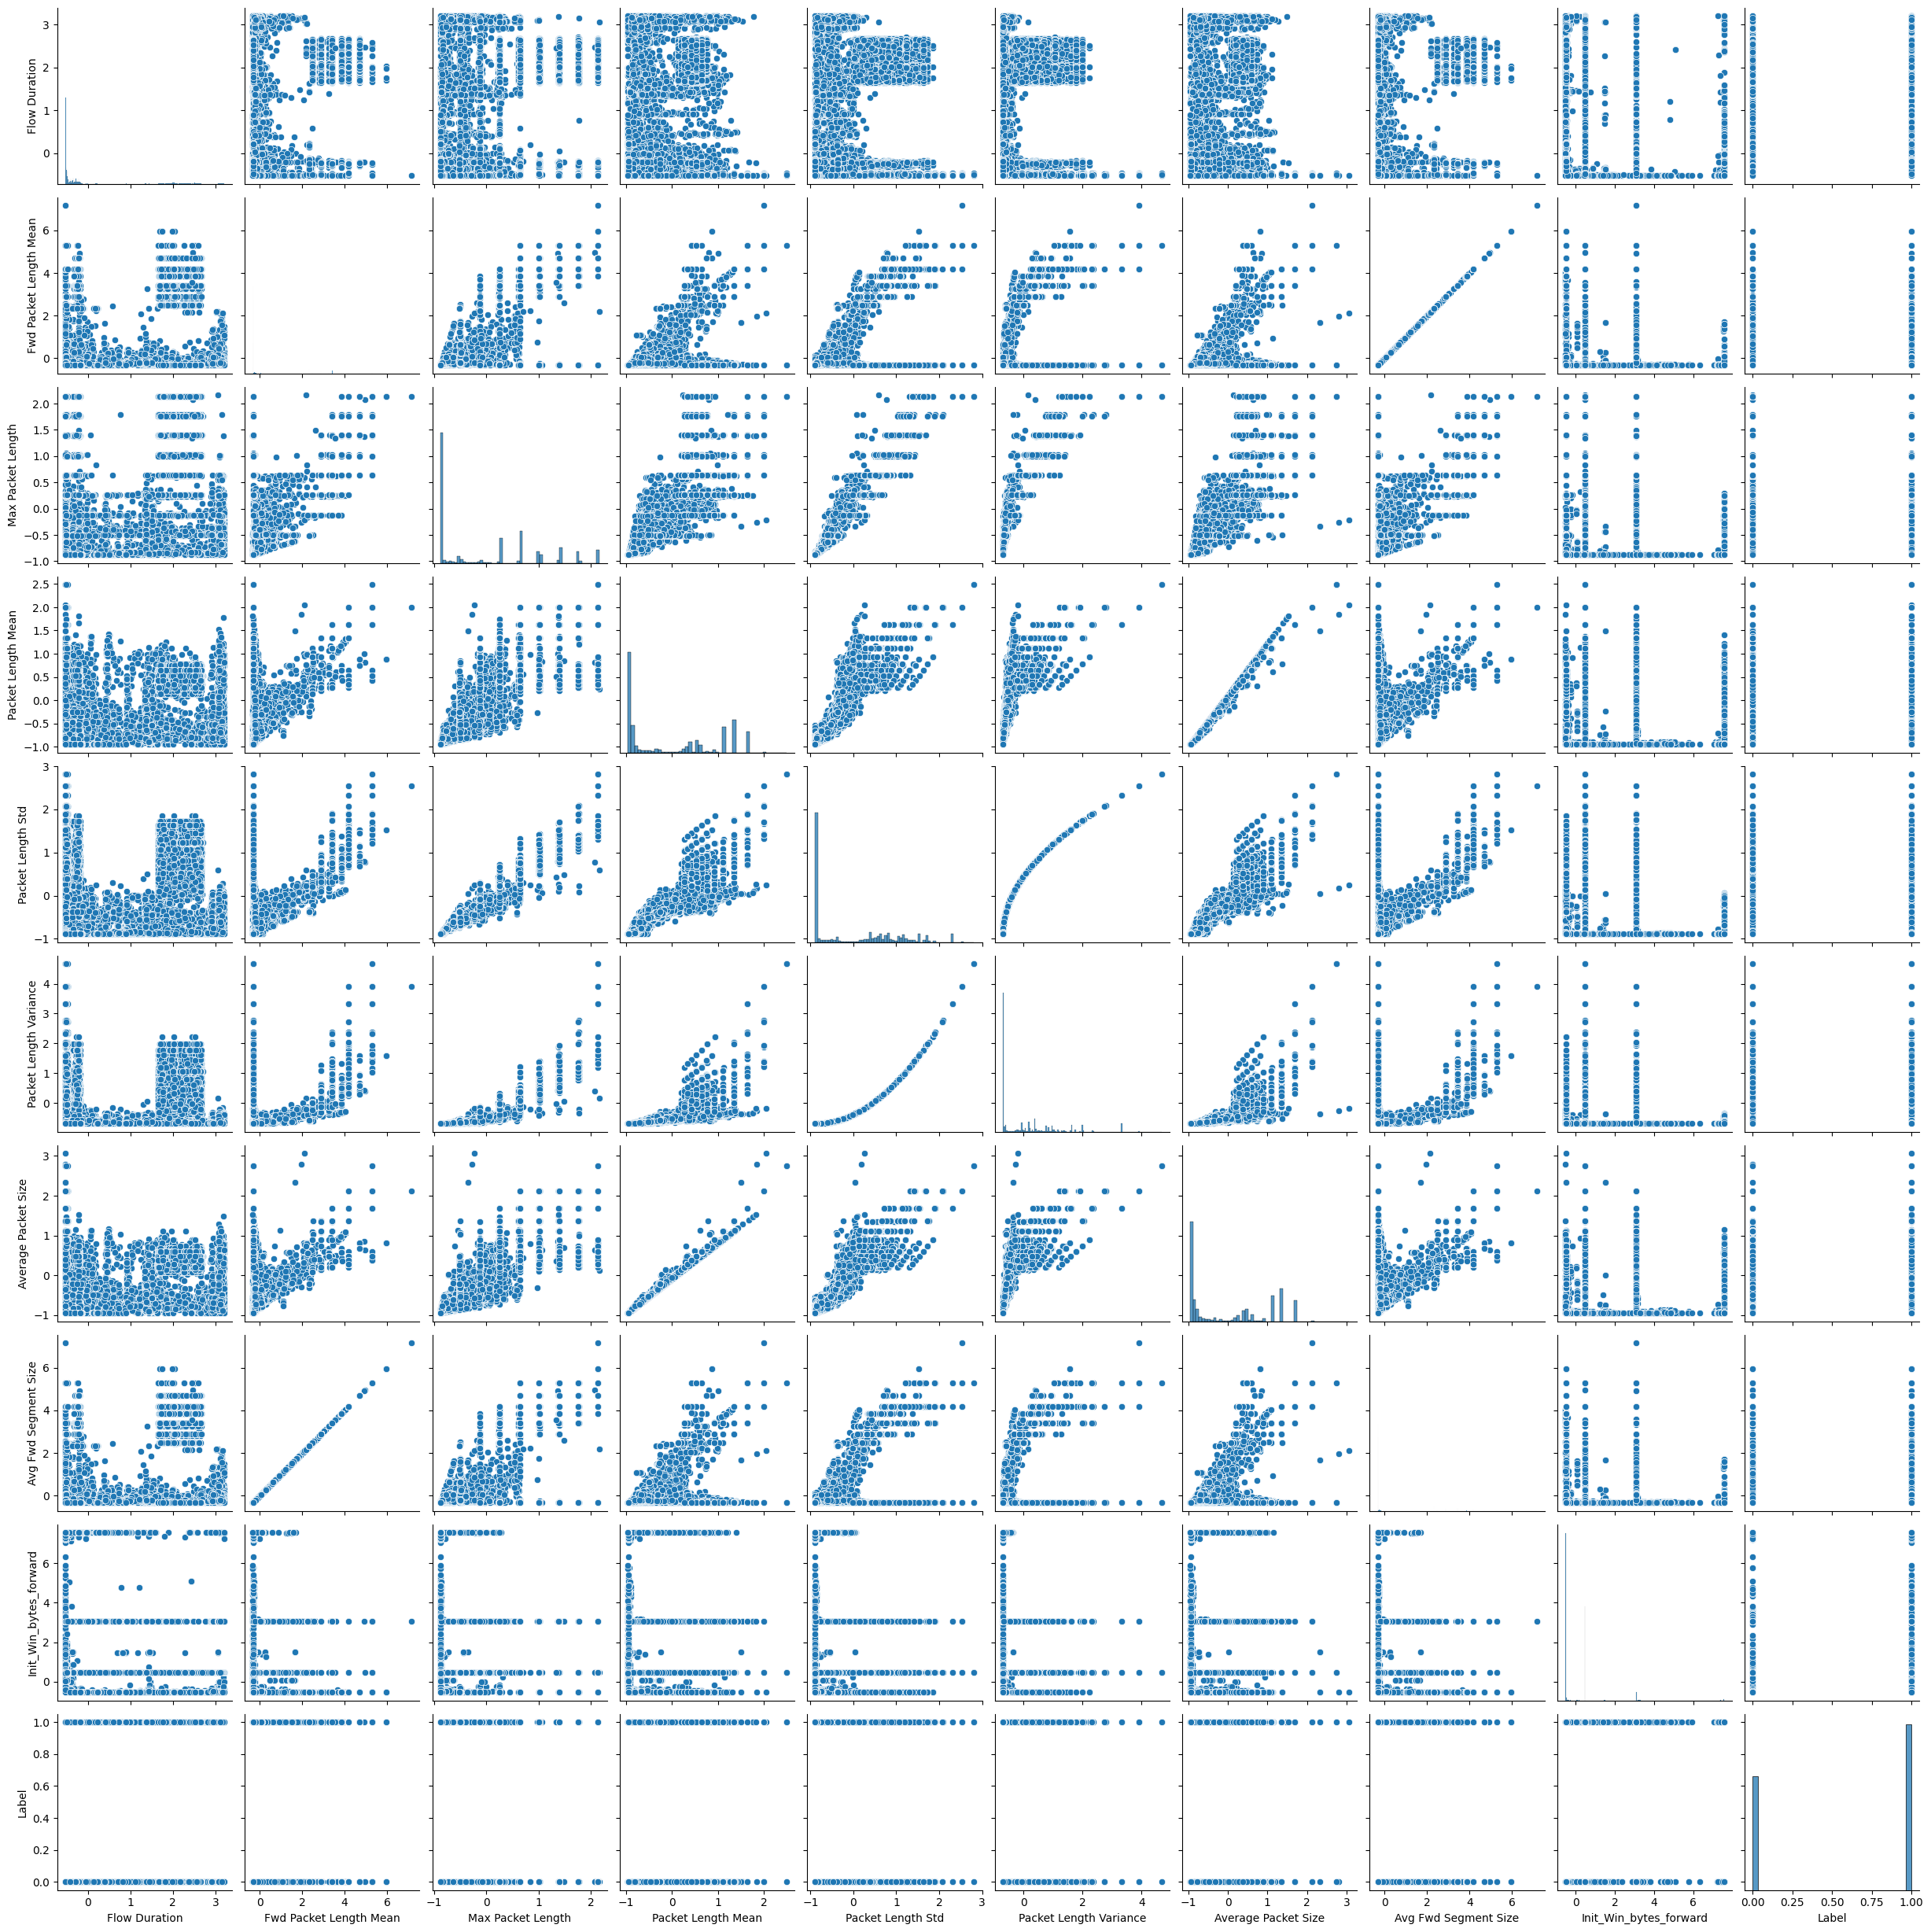

In [10]:
import seaborn as sns

sns.pairplot(pd.concat([X_train_scaled, y_train], axis=1))

Observation from plots:

1. Linear relation between 'Forward Packet Length Mean' and 'Average Forward Segment Size'
2. Both 'Packet Length Variance' and 'Packet Length Std' have been included in the features list, even though they have a quadratic relationship

Note: Reason for including the linear and quadratically redundant features has not been given. Ablation studies performed with the model below to validate if these features are useful or not.

In [11]:
# Converting datasets to numpy arrays to pass to the model 

X_train_scaled_np = np.array(X_train_scaled)
y_train = np.array(y_train)
X_test_scaled_np = np.array(X_test_scaled)
y_test = np.array(y_test)

Model creation and training

In [12]:

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


def build_model(X_inp):
    # Model object
    model = Sequential()

    # Input layer
    model.add(Dense(64, input_dim=X_inp.shape[1], activation='tanh'))

    # Hidden layers
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='tanh'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compiling
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model_base = build_model(X_train_scaled_np)

# Early Stopping
early_stopping = tensorflow.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

d:\myprogs\DdosDetection\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Training

epochs = 30
batch_size = 32

history = model_base.fit(X_train_scaled_np, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8608 - loss: 0.2656 - val_accuracy: 0.9180 - val_loss: 0.1885
Epoch 2/30
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9123 - loss: 0.1935 - val_accuracy: 0.9208 - val_loss: 0.1826
Epoch 3/30
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9176 - loss: 0.1843 - val_accuracy: 0.9185 - val_loss: 0.1833
Epoch 4/30
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9195 - loss: 0.1812 - val_accuracy: 0.9229 - val_loss: 0.1770
Epoch 5/30
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9206 - loss: 0.1792 - val_accuracy: 0.9216 - val_loss: 0.1778
Epoch 6/30
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9225 - loss: 0.1771 - val_accuracy: 0.9198 - val_loss: 0.1803
Epoch 7/30
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9227 - loss: 0.1770 - val_accuracy: 0.9184 - val_loss: 0.1818
Epoch 8/30
4301/4301 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9231 - loss: 0

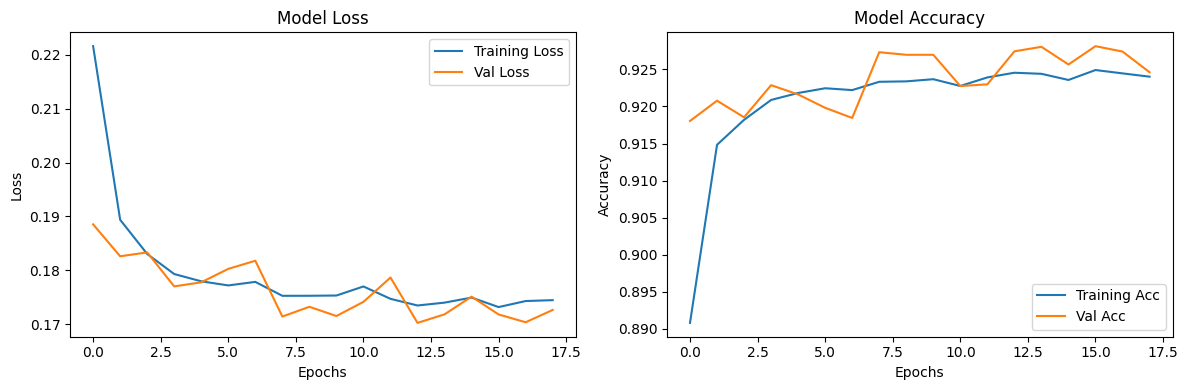

In [14]:
# Plot training curves
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

Evaluating Model

1345/1345 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     17513
           1       0.90      0.98      0.94     25496

    accuracy                           0.93     43009
   macro avg       0.94      0.92      0.92     43009
weighted avg       0.93      0.93      0.93     43009



Confusion Matrix


<Axes: >

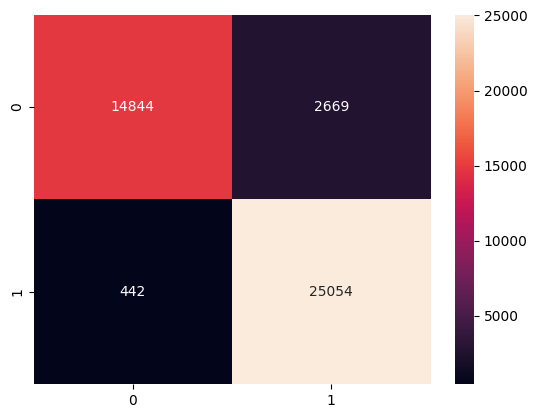

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model_base.predict(X_test_scaled_np) > 0.5).astype('int')

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print('Classification Report \n', cr)
print('\n')
print('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='d')

Hyperparameter Tuning

In [16]:
# Finding optimal hyperparameters for the model
import keras_tuner as kt
from keras_tuner import Hyperband


def build_model(hp):
    model = Sequential()
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', ['relu', 'tanh'])

    model.add(Dense(units=hp_units, activation=hp_activation, input_dim=X_train_scaled.shape[1]))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

early_stopping = tensorflow.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

tuner = Hyperband(build_model, objective='val_accuracy', max_epochs=5, factor=3)
tuner.search(X_train_scaled, y_train, epochs=25, validation_split=0.2, callbacks=[early_stopping])

Reloading Tuner from .\untitled_project\tuner0.json



KeyboardInterrupt



Ablation Study

In [17]:
# Dropping 'Avg Fwd Segment Size' and 'Packet Length Variance' 

X_train_dropped = np.array(X_train_scaled.drop(['Avg Fwd Segment Size', 'Packet Length Variance'], axis=1))

model_abl = build_model(X_inp=X_train_dropped)

early_stopping_abl = tensorflow.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model_abl.fit(X_train_dropped, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping_abl])

TypeError: build_model() got an unexpected keyword argument 'X_inp'

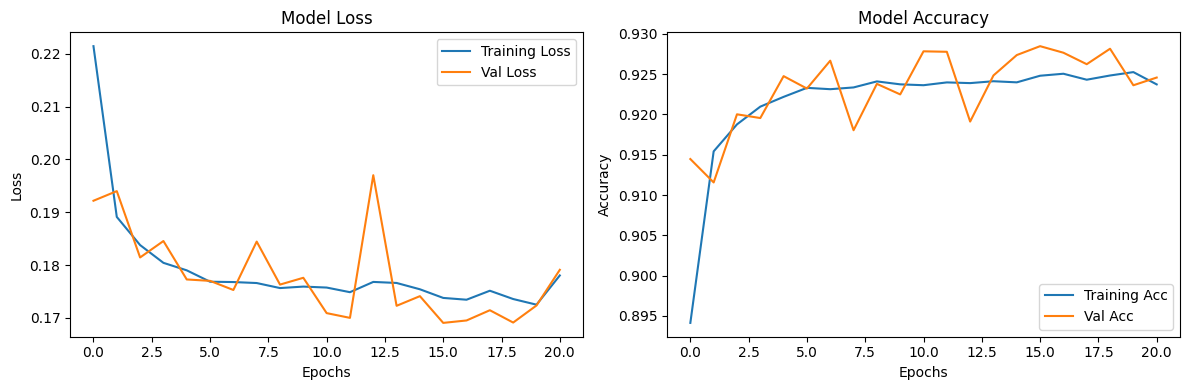

In [109]:
# Plot training curves
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

1345/1345 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step
Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     17513
           1       0.90      0.98      0.94     25496

    accuracy                           0.93     43009
   macro avg       0.94      0.92      0.92     43009
weighted avg       0.93      0.93      0.93     43009



Confusion Matrix


<Axes: >

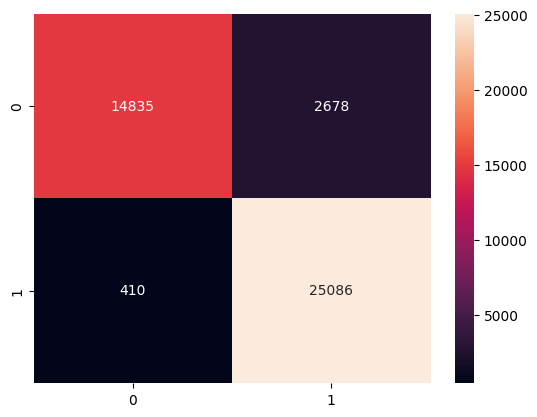

In [110]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

X_test_dropped = np.array(X_test_scaled.drop(['Avg Fwd Segment Size', 'Packet Length Variance'], axis=1))

y_pred = (model_abl.predict(X_test_dropped) > 0.5).astype('int')

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print('Classification Report \n', cr)
print('\n')
print('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='d')

Saving Models

In [19]:
import pickle

with open('./saved_models/model_baseline.pkl', 'wb') as file:
    pickle.dump(model_base, file)

with open('./saved_models/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# with open('./saved_models/model_ablation.pkl', 'wb') as file:
#     pickle.dump(model_abl, file)

## Results

* Implemented the Multi-Layer Perceptron (MLP) without Genetic Algorithm, and achieved an accuracy of 93%. It is slightly better than what was achieved with MLP in the paper (92.5%).

* Observed 2 redundant features from the pairwise distribution plots of the data:
1. Linear relation between 'Forward Packet Length Mean' and 'Average Forward Segment Size'.
2. Both 'Packet Length Variance' and 'Packet Length Std' have been included in the features list, even though they have a quadratic relationship.

* Performed ablation study on the redundant features observed and concluded that removing 'Average Forward Segment Size' and 'Packet Length Variance' does not affect the accuracy and other metrics of the MLP. If using current MLP in the federated setup, we can remove these 2 features from the dataset, to have a total of 7 features for classification. Thus, our dataset size can be reduced further, which will be helpful for the edge devices in our federated setup.

* When using GA with MLP, accuracy can be boosted up to 98.8% as per the paper. Hence, assuming the redundant features contribute towards the GA, there is a tradeoff between accuracy and reduced feature size, which will need to be considered for the federated setup.

* TO DO : Perhaps redundant features contribute towards the Genetic Algo. Moving forward, further read and understand the GA, and check if these features contribute to it. 